# Telecom Customer Churn Classification

9/21/2018

Mooyoung Lee

## <font color=blue>Objective:

Find a model classifying customer churn with high accuracy

## <font color=blue>Dataset:</font>

Data source: https://www.kaggle.com/abhinav89/telecom-customer/data. 

Feature information: http://m.library2.smu.ca/bitstream/handle/01/22018/yu_wei_masters_2005.PDF?sequence=1. 

## <font color=blue>Summary:</font>

For data preperation, features with string values are converted either into numeric values or dummy variables.  Missing data is imputed with mean values for now, which is not the best way to handle missing values. 

Multiple classifiers are tested with only 10,000 samples to see which classifier shows the highest accuracy.  Boosted tree showed the higst accuracy as 62% from 3-fold cross validation. 

Boosted tree algorithm took so much time w/ whole data set, 100,000 rows.  So random forest algorithm is tried and tuned.  The tuned Random Forest model showed only 58% accuracy from 3-fold cross validation.

Neural Net models are tried. 4-layer feed forward model showed 83% of training accuracy but the test accuracy was 56%.  6-layer feed forward model showed 70% training accuracy and 58% test accuracy.  All neural net model showed overfitting upto this point.  Assume that the neural net model will not show the accuracy of high 60%.  


### Data Loading and Checking

The CSV file is imported using pandas below.  21 (categorical) attributes are loaded as object which indicate that the contents are string values. 79 attributes have numerical values.   

In [1]:
# load the dataset and packages
import pandas as pd
import numpy as np
# from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('data/Telecom_customer churn.csv') # read in the csv file
df.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [2]:
# Data Frame Size
df.shape

(100000, 100)

In [3]:
# data frame with only string data
df_obj = df.loc[:, df.dtypes == object]
col_list_obj = list(df_obj)
obj_len = len(col_list_obj) # number of object attributes
print("Number of Categorical Attributes = {}".format(obj_len))

Number of Categorical Attributes = 21


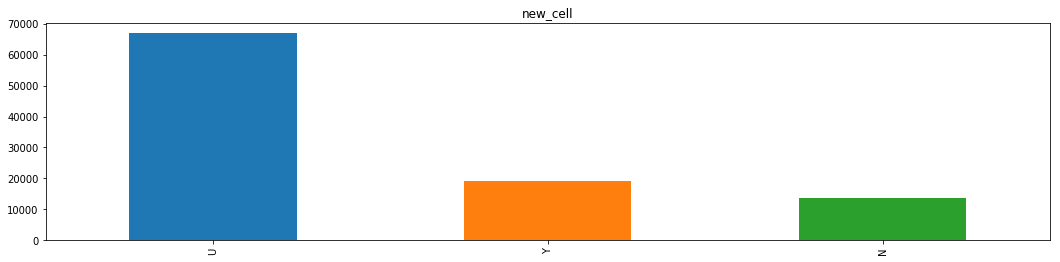

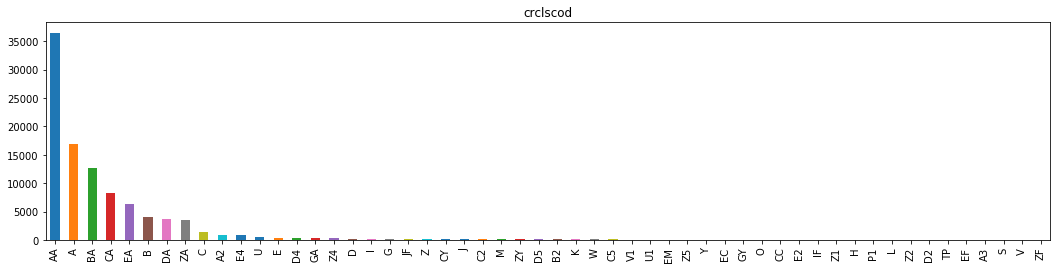

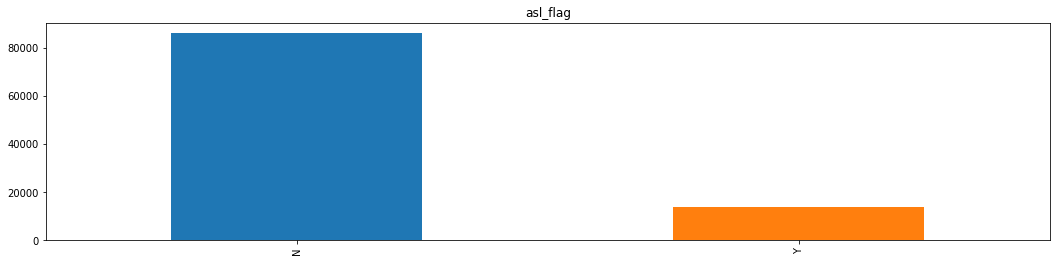

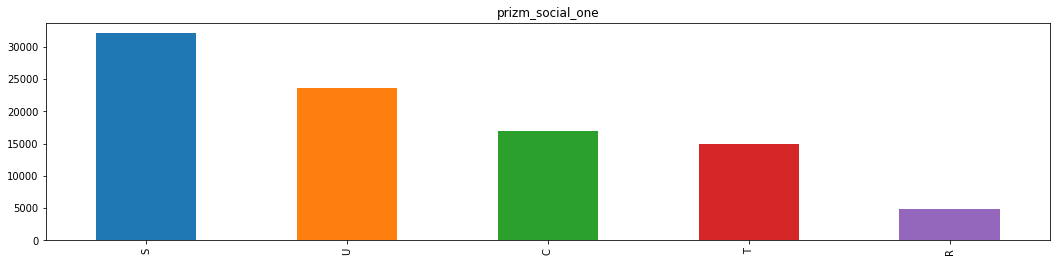

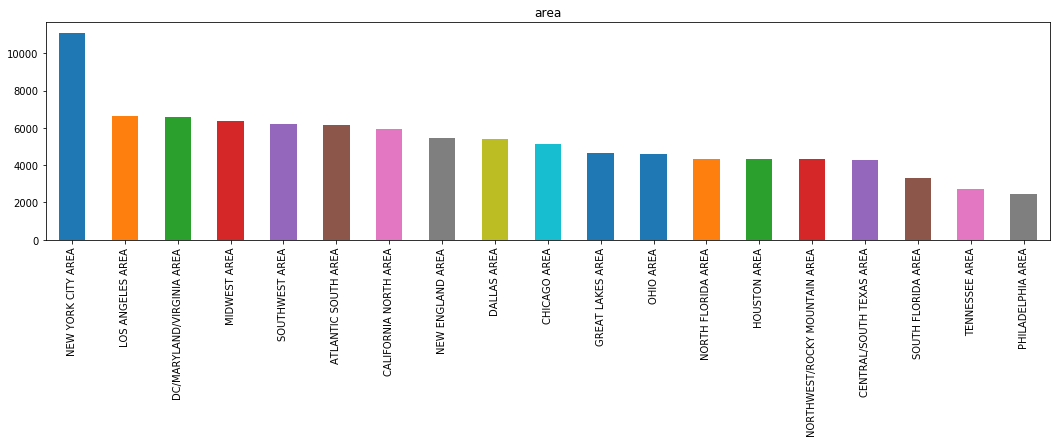

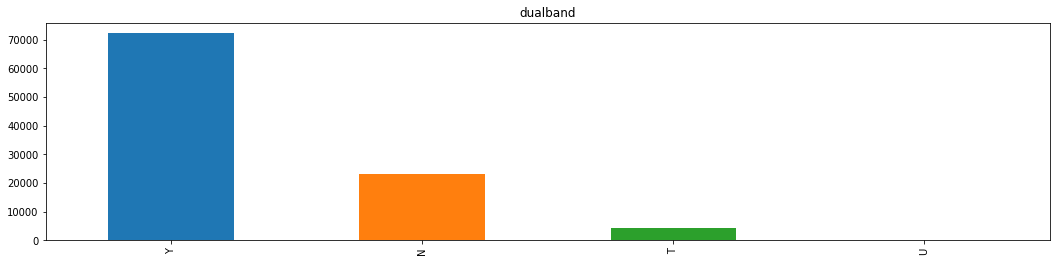

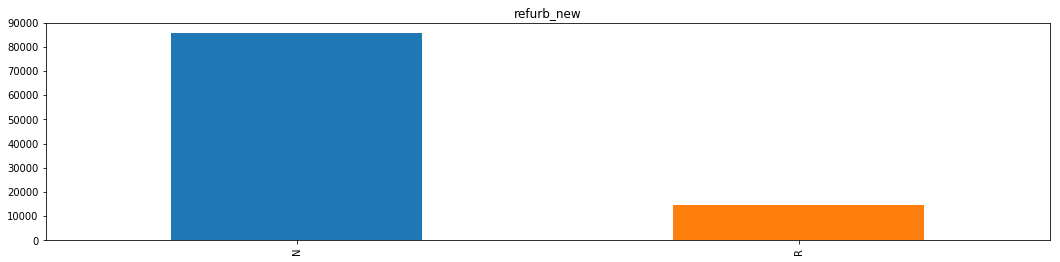

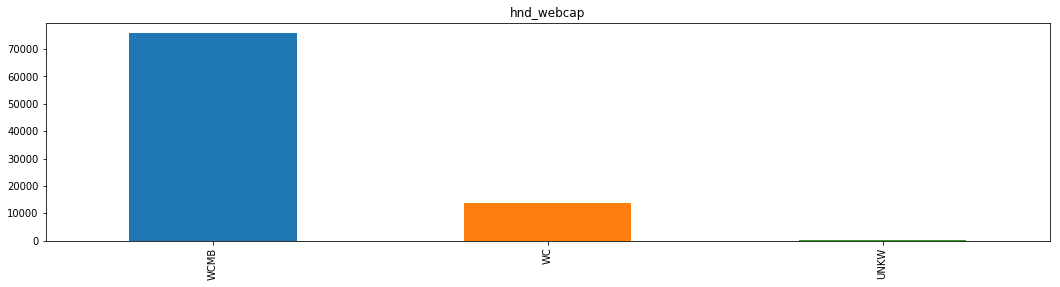

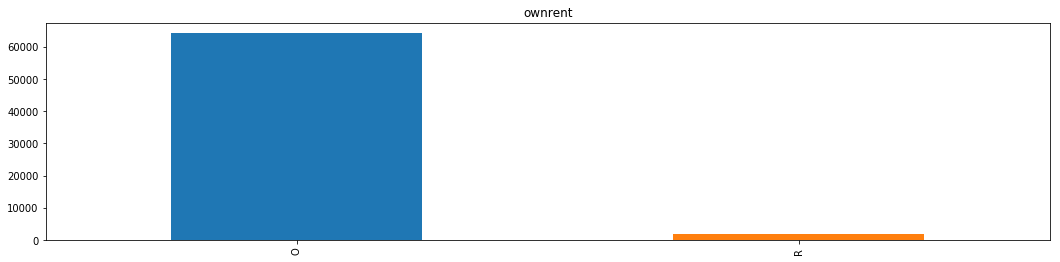

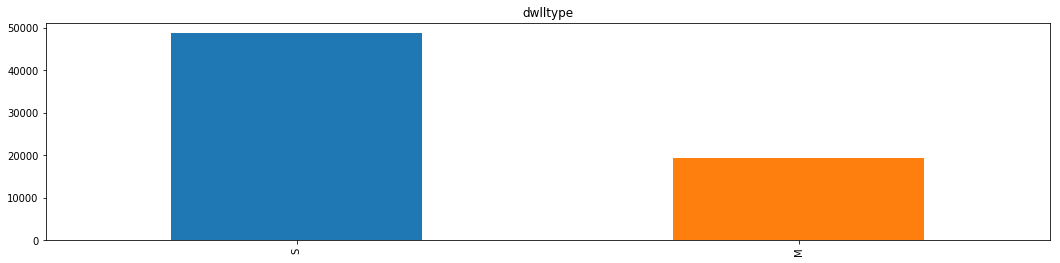

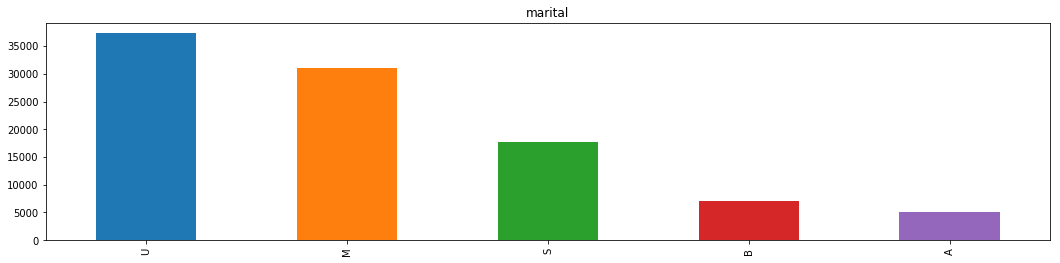

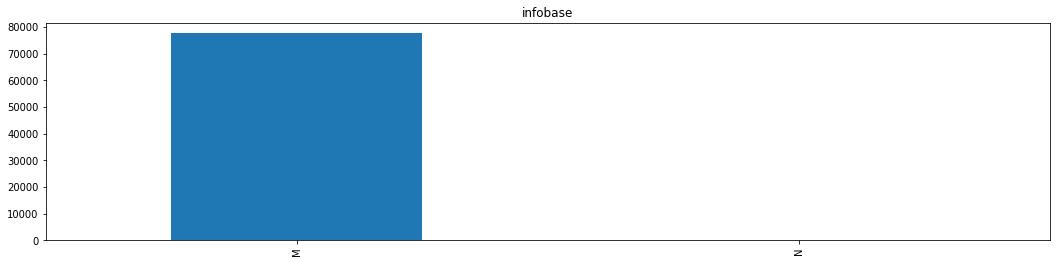

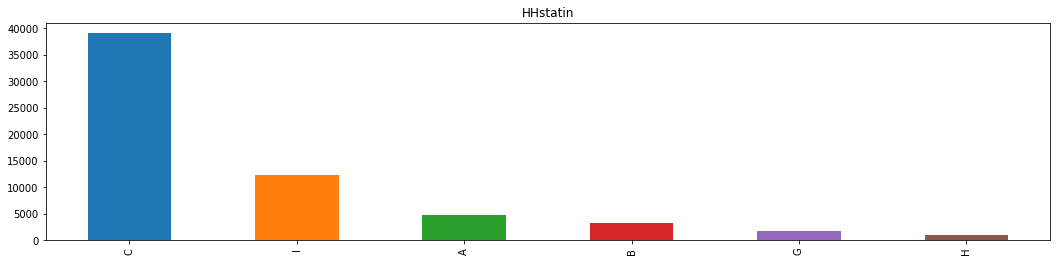

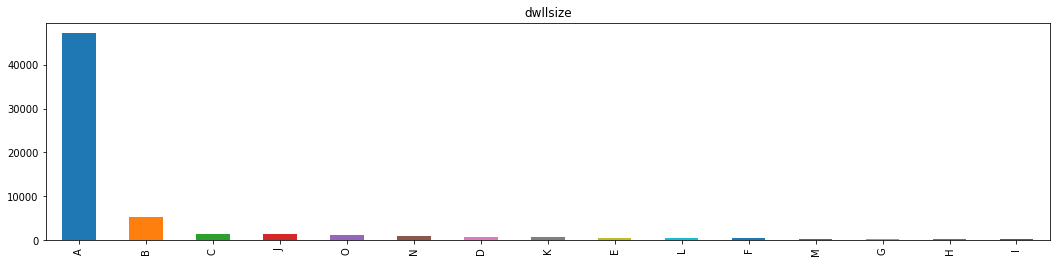

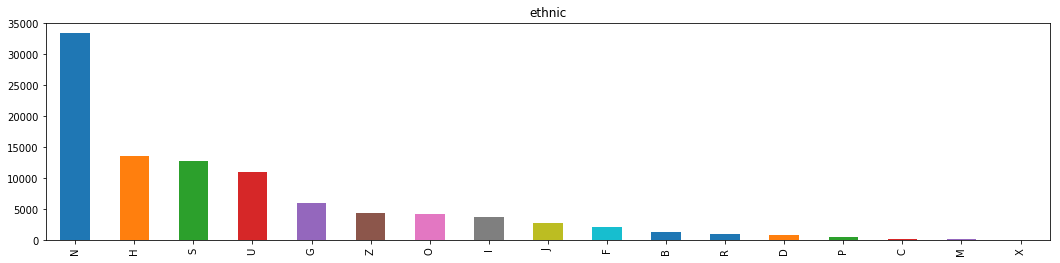

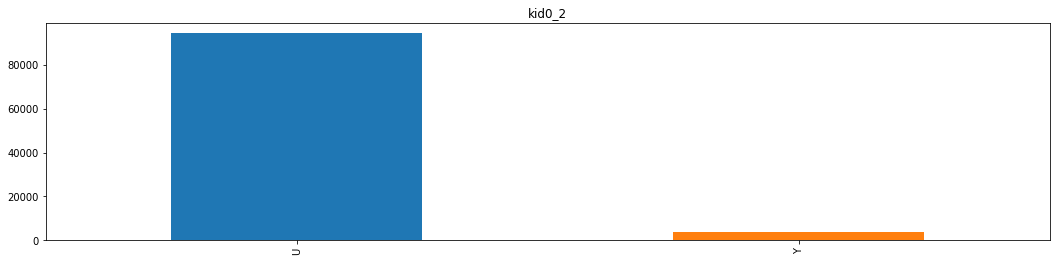

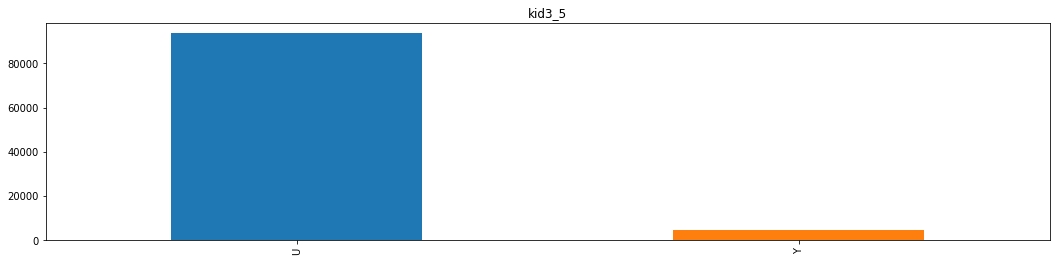

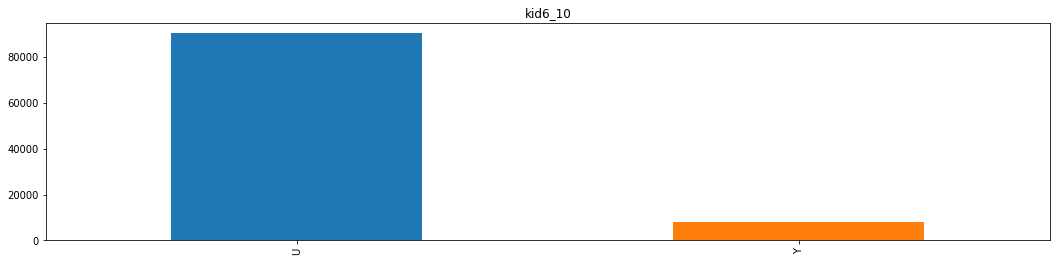

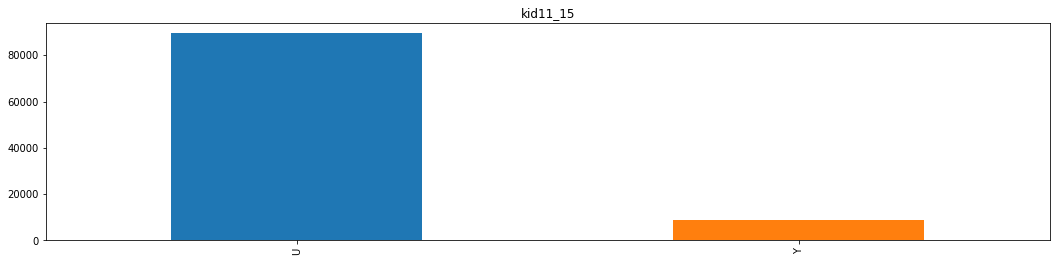

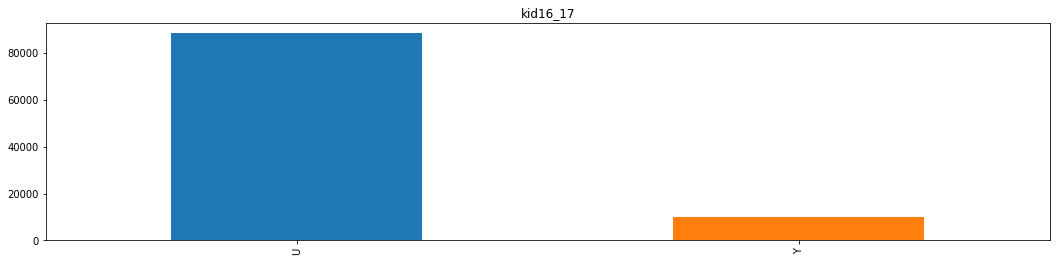

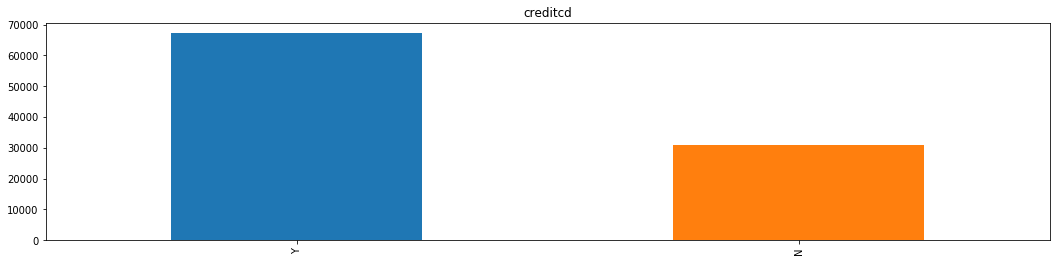

In [4]:
# Frequency plot for Categorical attributes

for i in range(0,21):
    plt.figure(figsize = (18,4))
    ax = df[col_list_obj[i]].value_counts().plot(kind='bar')
    plt.title(col_list_obj[i])
    plt.show()

### Levels of Categorical Variables

#### Most of the attributes shows only two or three levels.  The attributes with large number of levels are as follows:

- 'CRCLSCOD' : Credit class code
- 'AREA' : Geographic area
- 'DWLLSIZE' : Dwelling size
- 'ETHNIC' : Ethnicity roll-up code

#### The following attributes can be converted into numerical type since they have only two levels:
- 'asl_flag' : Account spending limit (N/Y)
- 'refurb_new' : Handset: refurbished or new (N/R)
- 'ownrent' : Home owner/renter status (O/R)
- 'dwlltype' : Dwelling unit type (S/M)
- 'infobase' : InfoBase match (M/N)
- 'kid0_2'   : Child 0 - 2 years of age in household (U/Y)
- 'kid3_5'   : Child 3 - 5 years of age in household (U/Y)
- 'kid6_10'  : Child 6 - 1 0 years of age in household (U/Y)
- 'kid11_15' : Child 11- 15 years of age in household (U/Y)
- 'kid16_17' : Child 16- 17 years of age in household (U/Y)
- 'creditcd' : Credit card indicator (Y/N)

**'InfoBase** is not balanced.

Below, the level frequency shows that more than 99.7% of 'infobase' value is M. This attribute will probably not explain much about the churn. 

In [5]:
# Frequency check for 'infobase' levels

print(' InfoBase Levels : \n', df['infobase'].value_counts())
print('\n Churn Levles : \n', df['churn'].value_counts())

 InfoBase Levels : 
 M    77697
N      224
Name: infobase, dtype: int64

 Churn Levles : 
 0    50438
1    49562
Name: churn, dtype: int64


## <font color=blue>Data Transformation</font>

Convert categorical attributes into numerical and dummy variables

In [6]:
df2 = df
df2.asl_flag = df2.asl_flag.replace(['N', 'Y'], [0, 1])
df2.refurb_new = df2.refurb_new.replace(['N', 'R'], [0, 1])
df2.ownrent = df2.ownrent.replace(['R', 'O'], [0, 1])
df2.dwlltype = df2.dwlltype.replace(['S', 'M'], [0, 1])
df2.infobase = df2.infobase.replace(['N', 'M'], [0, 1])
df2.kid0_2 = df2.kid0_2.replace(['U', 'Y'], [0, 1])
df2.kid3_5 = df2.kid3_5.replace(['U', 'Y'], [0, 1])
df2.kid6_10 = df2.kid6_10.replace(['U', 'Y'], [0, 1])
df2.kid11_15 = df2.kid11_15.replace(['U', 'Y'], [0, 1])
df2.kid16_17 = df2.kid16_17.replace(['U', 'Y'], [0, 1])
df2.creditcd = df2.creditcd.replace(['N', 'Y'], [0, 1])
df2.dwllsize = df2.dwllsize.replace(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [7]:
# Transform into dummy variable
df2 = pd.get_dummies(df2)
df2.shape

(100000, 207)

## <font color=blue>Missing value Imputation

- Since there are too many missing values, 40~50%, 
- missing values will be imputed with mean values and 
- the imputed values will be labeled using separate features. 

In [8]:
cnt_null = pd.DataFrame(df2.isnull().sum().sort_values(ascending = False),
                       columns = ['count'])
# cnt_null['name'] = cnt_null.index

features_null = cnt_null.loc[cnt_null['count']>0].index
cnt_null.head()

,count
numbcars,49366
dwllsize,38308
ownrent,33706
dwlltype,31909
lor,30190


In [9]:
# new features w/ null labeling and

for i in features_null:
    df2[i+'_null'] = df2[i].isnull()

In [10]:
# imputing missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='mean')
df3 = pd.DataFrame(imputer.fit_transform(df2), columns = list(df2))

### Verify imputation

In [11]:
np.mean(df2).head()

rev_Mean        58.719985
mou_Mean       513.559937
totmrc_Mean     46.179136
da_Mean          0.888828
ovrmou_Mean     41.072247
dtype: float64

In [12]:
df3.tail()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,mou_Mean_null,totmrc_Mean_null,da_Mean_null,ovrmou_Mean_null,vceovr_Mean_null,datovr_Mean_null,refurb_new_null,phones_null,models_null,eqpdays_null
99995,58.719985,513.559937,46.179136,0.888828,41.072247,13.55956,13.295062,0.261318,1.286405,-13.933818,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
99996,58.719985,513.559937,46.179136,0.888828,41.072247,13.55956,13.295062,0.261318,1.286405,-13.933818,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
99997,58.719985,513.559937,46.179136,0.888828,41.072247,13.55956,13.295062,0.261318,1.286405,-13.933818,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
99998,58.719985,513.559937,46.179136,0.888828,41.072247,13.55956,13.295062,0.261318,1.286405,-13.933818,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
99999,58.719985,513.559937,46.179136,0.888828,41.072247,13.55956,13.295062,0.261318,1.286405,-13.933818,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [13]:
df3.isnull().sum().sum()

0

## Data split and scale

Drop 'Customer_ID' as well since it should not affect the churn

In [14]:
X = df3.drop(['churn','Customer_ID'], axis=1)

In [15]:
y = df3['churn']
y.head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: churn, dtype: float64

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [17]:
X.min(), X.max()

(0.0, 1.0000000000000002)

## <span style="color:blue"> Preliminary classifier selection


In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier


from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

names = ["Logistic Regression", "Nearest Neighbors", "Linear SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Extra Random Trees", "Boosted Tree"]

# Default parameters are used for all algorithms.
classifiers = [
    LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, random_state = 0),
    KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30),
    LinearSVC(C = 1, loss = 'hinge', random_state = 0),
#     SVC(kernel = 'rbf', C = 1, gamma = 'auto', random_state = 0), #, "RBF SVM"
    GaussianProcessClassifier(random_state = 0),
    DecisionTreeClassifier(criterion = 'gini', max_depth = None, min_samples_leaf=1, random_state = 0),
    RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, random_state = 0),
    MLPClassifier(activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', random_state = 0),
    AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state = 0),
    GaussianNB(priors=None),
    QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0, tol=0.0001),
    ExtraTreesClassifier(n_estimators=10, criterion='gini', max_depth=None, random_state = 0),
    GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, random_state = 0)]


# Sampling only 10,000 samples for this process
np.random.seed(1)
sampleRow = np.random.choice(len(y),10000) # samples row numbers
X_sample = X[sampleRow,:] # samples for scatter plot 
y_sample = y[sampleRow]

# Prediction Accuracy

for name, clf in zip(names, classifiers):
    t0 = time.time()
    acc = cross_val_score(clf, X_sample, y_sample)
    print(name, np.round(acc,3), ' Elapse Time: ', time.time()-t0)

Logistic Regression [0.573 0.575 0.563]  Elapse Time:  0.9886651039123535
Nearest Neighbors [0.533 0.531 0.535]  Elapse Time:  31.3619225025177
Linear SVM [0.581 0.572 0.559]  Elapse Time:  0.5231466293334961
Gaussian Process [0.568 0.567 0.56 ]  Elapse Time:  181.83455634117126
Decision Tree [0.574 0.581 0.586]  Elapse Time:  1.4954497814178467
Random Forest [0.593 0.573 0.585]  Elapse Time:  0.8138751983642578


C:\Users\ML\Anaconda3\envs\kerasGPU\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ML\Anaconda3\envs\kerasGPU\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net [0.573 0.565 0.574]  Elapse Time:  33.0787308216095
AdaBoost [0.62  0.6   0.615]  Elapse Time:  6.994684934616089
Naive Bayes [0.509 0.518 0.506]  Elapse Time:  0.22453522682189941


C:\Users\ML\Anaconda3\envs\kerasGPU\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\ML\Anaconda3\envs\kerasGPU\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\ML\Anaconda3\envs\kerasGPU\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA [0.499 0.52  0.497]  Elapse Time:  0.6217687129974365
Extra Random Trees [0.571 0.571 0.571]  Elapse Time:  0.7759239673614502
Boosted Tree [0.623 0.623 0.629]  Elapse Time:  20.523274660110474


## Feature importance by Gradient Boosting classifier

In [25]:
clf =  GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, random_state = 0)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [26]:
col_names = list(df3.columns.values)[0:]
del col_names[col_names.index('churn')]
del col_names[col_names.index('Customer_ID')]

Importance = pd.DataFrame({'Feature':col_names, 'Importance':clf.feature_importances_})
Importance.sort_values(by = 'Importance', ascending = False, inplace = True)
Importance.reset_index(drop=True).head(20)

,Feature,Importance
0,months,0.102955
1,mou_Mean,0.093590
2,eqpdays,0.078230
3,change_mou,0.074622
4,totmrc_Mean,0.054066
5,avgqty,0.044864
6,hnd_price,0.044801
7,mou_cvce_Mean,0.033352
8,uniqsubs,0.025096
9,change_rev,0.021887


## <span style="color:blue"> Model Optimization: Gradient Boosting
    
- Gradient boosting failed since it takes days to run with this dataset.
- Random Forest classifier tuning did not help much to increase accuracy. 
- No hope in decision trees and support vector machines for this dataset.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

tuned_parameters={'n_estimators':[100,200,300], 
                 'max_depth':[10, 20, 30, 50, 100]}

clf = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, cv=3, n_iter = 10)
clf.fit(X, y)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")

C:\Users\ML\Anaconda3\envs\kerasGPU\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Best parameters set found on development set:

{'n_estimators': 300, 'max_depth': 50}

Grid scores on development set:

0.586 (+/-0.030) for {'n_estimators': 200, 'max_depth': 30}
0.574 (+/-0.016) for {'n_estimators': 100, 'max_depth': 10}
0.586 (+/-0.025) for {'n_estimators': 200, 'max_depth': 50}
0.582 (+/-0.029) for {'n_estimators': 100, 'max_depth': 30}
0.588 (+/-0.027) for {'n_estimators': 300, 'max_depth': 50}
0.586 (+/-0.026) for {'n_estimators': 300, 'max_depth': 20}
0.584 (+/-0.027) for {'n_estimators': 100, 'max_depth': 20}
0.586 (+/-0.027) for {'n_estimators': 200, 'max_depth': 100}
0.573 (+/-0.019) for {'n_estimators': 300, 'max_depth': 10}
0.573 (+/-0.020) for {'n_estimators': 200, 'max_depth': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.


# Neural Network Model

In [23]:
X.shape

(100000, 241)

# 4 layer feed forward model

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
# Call back obj
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
callbacks = [EarlyStopping(monitor='loss', patience= 2),
             ModelCheckpoint(filepath='best_model.h5', monitor='loss', save_best_only=True)]
# train/test split
from sklearn.model_selection import StratifiedKFold
cv_obj = StratifiedKFold(n_splits=10, shuffle= True, random_state= 1)

result =[]
for train_index, test_index in cv_obj.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('\nNew CV Train/Test size: ', len(y_train), len(y_test))
    
    # NeuralNet 
    model = Sequential()
    model.add(Dense(241, input_dim= X_train.shape[1], kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, kernel_initializer='he_normal', activation ='sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')  # Configures the model for training
    model.fit(X_train, y_train, epochs=1000, batch_size = 100, callbacks=callbacks)  # Train model

    final = model.predict_classes(X_test)
    conf = confusion_matrix(y_true = y_test, y_pred = final)
    acc = accuracy_score(y_true = y_test, y_pred = final)
    roc = roc_auc_score(y_true = y_test, y_score = final)

    result.append([roc, acc]+ conf.ravel().tolist())   # save result scores
    
    break # run only for the first CV set
# Result Summary
result_fold = pd.DataFrame(result, columns = ['ROC_AUC','Accuracy','TN','FP','FN','TP'])
print('\nCV result :\n', result_fold)
print('\nCV average :\n', result_fold.mean())

Using TensorFlow backend.



New CV Train/Test size:  89999 10001
Epoch 1/1000
89999/89999 [==============================] - 9s 100us/step - loss: 0.6817 - acc: 0.5613
Epoch 2/1000
89999/89999 [==============================] - 7s 73us/step - loss: 0.6722 - acc: 0.5813
Epoch 3/1000
89999/89999 [==============================] - 7s 74us/step - loss: 0.6670 - acc: 0.5921
Epoch 4/1000
89999/89999 [==============================] - 7s 76us/step - loss: 0.6614 - acc: 0.6014
Epoch 5/1000
89999/89999 [==============================] - 7s 75us/step - loss: 0.6558 - acc: 0.6084
Epoch 6/1000
89999/89999 [==============================] - 8s 86us/step - loss: 0.6499 - acc: 0.6161
Epoch 7/1000
89999/89999 [==============================] - 7s 78us/step - loss: 0.6417 - acc: 0.6249
Epoch 8/1000
89999/89999 [==============================] - 7s 75us/step - loss: 0.6323 - acc: 0.6345
Epoch 9/1000
89999/89999 [==============================] - 7s 72us/step - loss: 0.6229 - acc: 0.6441
Epoch 10/1000
89999/89999 [================

# 7 layer feed forward model

- Increased dropout to 0.3 to control overfitting.

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
# Call back obj
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
callbacks = [EarlyStopping(monitor='loss', patience= 2),
             ModelCheckpoint(filepath='best_model.h5', monitor='loss', save_best_only=True)]
# train/test split
from sklearn.model_selection import StratifiedKFold
cv_obj = StratifiedKFold(n_splits=10, shuffle= True, random_state= 1)

result =[]
for train_index, test_index in cv_obj.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('\nNew CV Train/Test size: ', len(y_train), len(y_test))
    
    # NeuralNet 
    model = Sequential()
    model.add(Dense(241, input_dim= X_train.shape[1], kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='he_normal', activation ='sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')  # Configures the model for training
    model.fit(X_train, y_train, epochs=1000, batch_size = 100, callbacks=callbacks)  # Train model

    final = model.predict_classes(X_test)
    conf = confusion_matrix(y_true = y_test, y_pred = final)
    acc = accuracy_score(y_true = y_test, y_pred = final)
    roc = roc_auc_score(y_true = y_test, y_score = final)

    result.append([roc, acc]+ conf.ravel().tolist())   # save result scores
    
    break # run only for the first CV set
# Result Summary
result_fold = pd.DataFrame(result, columns = ['ROC_AUC','Accuracy','TN','FP','FN','TP'])
print('\nCV result :\n', result_fold)
print('\nCV average :\n', result_fold.mean())


New CV Train/Test size:  89999 10001
Epoch 1/1000
89999/89999 [==============================] - 10s 108us/step - loss: 0.6921 - acc: 0.5307
Epoch 2/1000
89999/89999 [==============================] - 9s 99us/step - loss: 0.6815 - acc: 0.5654
Epoch 3/1000
89999/89999 [==============================] - 9s 104us/step - loss: 0.6767 - acc: 0.5769
Epoch 4/1000
89999/89999 [==============================] - 10s 117us/step - loss: 0.6736 - acc: 0.5845
Epoch 5/1000
89999/89999 [==============================] - 10s 108us/step - loss: 0.6708 - acc: 0.5884
Epoch 6/1000
89999/89999 [==============================] - 9s 102us/step - loss: 0.6678 - acc: 0.5939
Epoch 7/1000
89999/89999 [==============================] - 10s 108us/step - loss: 0.6654 - acc: 0.5987
Epoch 8/1000
89999/89999 [==============================] - 9s 105us/step - loss: 0.6623 - acc: 0.6021
Epoch 9/1000
89999/89999 [==============================] - 10s 107us/step - loss: 0.6595 - acc: 0.6059
Epoch 10/1000
89999/89999 [====

# 7 layer w/ increased dropout to 0.5

In [21]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
# Call back obj
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
callbacks = [EarlyStopping(monitor='loss', patience= 2),
             ModelCheckpoint(filepath='best_model.h5', monitor='loss', save_best_only=True)]
# train/test split
from sklearn.model_selection import StratifiedKFold
cv_obj = StratifiedKFold(n_splits=10, shuffle= True, random_state= 1)

result =[]
for train_index, test_index in cv_obj.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('\nNew CV Train/Test size: ', len(y_train), len(y_test))
    
    # NeuralNet 
    model = Sequential()
    model.add(Dense(241, input_dim= X_train.shape[1], kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(241, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='he_normal', activation ='sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')  # Configures the model for training
    model.fit(X_train, y_train, epochs=100, batch_size = 100, callbacks=callbacks)  # Train model

    final = model.predict_classes(X_test)
    conf = confusion_matrix(y_true = y_test, y_pred = final)
    acc = accuracy_score(y_true = y_test, y_pred = final)
    roc = roc_auc_score(y_true = y_test, y_score = final)

    result.append([roc, acc]+ conf.ravel().tolist())   # save result scores
    
    break # run only for the first CV set
# Result Summary
result_fold = pd.DataFrame(result, columns = ['ROC_AUC','Accuracy','TN','FP','FN','TP'])
print('\nCV result :\n', result_fold)
print('\nCV average :\n', result_fold.mean())


New CV Train/Test size:  89999 10001
Epoch 1/100
89999/89999 [==============================] - 11s 125us/step - loss: 0.7066 - acc: 0.5029
Epoch 2/100
89999/89999 [==============================] - 10s 112us/step - loss: 0.6933 - acc: 0.5131
Epoch 3/100
89999/89999 [==============================] - 10s 111us/step - loss: 0.6901 - acc: 0.5363
Epoch 4/100
89999/89999 [==============================] - 10s 111us/step - loss: 0.6861 - acc: 0.5528
Epoch 5/100
89999/89999 [==============================] - 10s 112us/step - loss: 0.6828 - acc: 0.5605
Epoch 6/100
89999/89999 [==============================] - 10s 112us/step - loss: 0.6812 - acc: 0.5675
Epoch 7/100
89999/89999 [==============================] - 10s 112us/step - loss: 0.6797 - acc: 0.5732
Epoch 8/100
89999/89999 [==============================] - 10s 112us/step - loss: 0.6784 - acc: 0.5742
Epoch 9/100
89999/89999 [==============================] - 10s 112us/step - loss: 0.6768 - acc: 0.5783
Epoch 10/100
89999/89999 [=========

# 6 layer w/ dropout to 0.3

In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
# Call back obj
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
callbacks = [EarlyStopping(monitor='loss', patience= 2),
             ModelCheckpoint(filepath='best_model.h5', monitor='loss', save_best_only=True)]
# train/test split
from sklearn.model_selection import StratifiedKFold
cv_obj = StratifiedKFold(n_splits=10, shuffle= True, random_state= 1)

result =[]
for train_index, test_index in cv_obj.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('\nNew CV Train/Test size: ', len(y_train), len(y_test))
    
    # NeuralNet 
    model = Sequential()
    model.add(Dense(241, input_dim= X_train.shape[1], kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(60, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(30, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(15, kernel_initializer='he_normal', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='he_normal', activation ='sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')  # Configures the model for training
    model.fit(X_train, y_train, epochs=1000, batch_size = 100, callbacks=callbacks)  # Train model

    final = model.predict_classes(X_test)
    conf = confusion_matrix(y_true = y_test, y_pred = final)
    acc = accuracy_score(y_true = y_test, y_pred = final)
    roc = roc_auc_score(y_true = y_test, y_score = final)

    result.append([roc, acc]+ conf.ravel().tolist())   # save result scores
    
    break # run only for the first CV set
# Result Summary
result_fold = pd.DataFrame(result, columns = ['ROC_AUC','Accuracy','TN','FP','FN','TP'])
print('\nCV result :\n', result_fold)
print('\nCV average :\n', result_fold.mean())


New CV Train/Test size:  89999 10001
Epoch 1/1000
89999/89999 [==============================] - 8s 89us/step - loss: 0.6940 - acc: 0.5144
Epoch 2/1000
89999/89999 [==============================] - 7s 79us/step - loss: 0.6854 - acc: 0.5550
Epoch 3/1000
89999/89999 [==============================] - 7s 80us/step - loss: 0.6798 - acc: 0.5724
Epoch 4/1000
89999/89999 [==============================] - 7s 83us/step - loss: 0.6762 - acc: 0.5803
Epoch 5/1000
89999/89999 [==============================] - 8s 85us/step - loss: 0.6738 - acc: 0.5849
Epoch 6/1000
89999/89999 [==============================] - 8s 85us/step - loss: 0.6712 - acc: 0.5907
Epoch 7/1000
89999/89999 [==============================] - 8s 85us/step - loss: 0.6691 - acc: 0.5952
Epoch 8/1000
89999/89999 [==============================] - 8s 86us/step - loss: 0.6669 - acc: 0.5980
Epoch 9/1000
89999/89999 [==============================] - 8s 86us/step - loss: 0.6648 - acc: 0.6012
Epoch 10/1000
89999/89999 [=================